In [0]:
# Taken from https://github.com/GunhoChoi/AnoGAN-Pytorch

In [1]:
!pip install comet-ml

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" # set gpu number to use


from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline
from IPython.display import clear_output
import random
import itertools
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from tqdm import tqdm_notebook
from torch.nn.functional import logsigmoid

# Постановка задачи

Задача поиска аномалий - находить объекты, отличные от нормальных данных

**Примеры:** поиск сбоев, атак, ботов и другого аномального поведения или объектов

Как правило, ***основное отличие задачи поиска аномалий от задачи бинарной классификации*** заключается в том, что ***аномалий*** в выборке ***намного меньше или нет вообще***!

В связи с этим, большинство алгоритмов поиска аномалий, таких как OneClass-SVM и Isolation Forest, основываются на ***гипотезе о компактности***, когда нормальные объекты образуют некоторый кластер или группу кластеров (см. рис. ниже), а аномалии выходят за пределы этих кластеров
![](https://developer.mindsphere.io/apis/analytics-anomalydetection/images/DBSCAN.png)


Для экспериментов будем использовать датасет рукописных цифр MNIST

In [2]:
anomaly_digit = 0 # какую цифру примем за аномалию

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
api = 'GGF21Vtrnid3Cgat9n1nL9Vcc'

In [3]:
# Зададим обучающую и тестовую выборки в PyTorch

def sample_noise(batch_size, dim):
    normal = torch.distributions.Normal(loc=0, scale=1)
    return normal.sample((batch_size, dim))

def shuffle(a,b):
    assert len(a) == len(b)
    start_state = random.getstate()
    random.shuffle(a)
    random.setstate(start_state)
    random.shuffle(b)

def fixed_anomaly_loader(anomaly_num, is_train=True, batch_size=256):
    mnist_train0 = dset.MNIST("../../data", train=is_train, 
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5]),
                            ]),
                            target_transform=None,
                            download=True)
    
    idx = mnist_train0.targets==anomaly_digit
    anomaly_num = min(anomaly_num, idx.sum().item())
    mnist_train0.targets = mnist_train0.targets[idx]
    mnist_train0.data = mnist_train0.data[idx]

    el = len((mnist_train0.targets))
    shuffle(mnist_train0.targets, mnist_train0.data)
    mnist_train0.targets = mnist_train0.targets[[True] * anomaly_num + [False] * (el - anomaly_num)]
    mnist_train0.data = mnist_train0.data[[True] * anomaly_num + [False] * (el - anomaly_num)]


    mnist_train1 = dset.MNIST("./", train=is_train, 
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5]),
                            ]),
                            target_transform=None,
                            download=True)

    idx = mnist_train1.targets!=anomaly_digit
    mnist_train1.targets = mnist_train1.targets[idx]
    mnist_train1.data = mnist_train1.data[idx]

    ds = torch.utils.data.ConcatDataset([mnist_train0, mnist_train1])

    loader = torch.utils.data.DataLoader(dataset=ds, batch_size=batch_size,shuffle=True)
    # DataLoader - вспомогательный класс PyTorch, который разбивает данные на батчи
    return loader

# Baseline
В качестве бейслайна попробуем обучить бинарный классификатор (аномалия/не аномалия) в условиях малого количества аномалий

## Задание 1
Обучите бинарный классификатор для поиска аномалий. Посмотрите на финальный ROC AUC 

In [4]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
            #nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, kernel_size=7, padding=3),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2), # 128 x 7 x 7
            nn.LeakyReLU(),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
model = AlexNet(num_classes=1)
model.to(device)
num_classes=1
criterion = nn.BCEWithLogitsLoss() # бинарная кросс-энтропия 
opt = torch.optim.Adam(model.parameters(), lr=0.005) # оптимизатор

num_anomalies = 50 # количество используемых аномалий. В обучении не должно использоваться больше указанного числа!
epoch = 25 # сколько циклов обучения (сколько раз прогоним всю обучаюшую выборку в процессе обучения)

In [5]:
torch.cuda.empty_cache()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/1ee0c56d9731405bb903efad716502fc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount [3]          : (10.0, 100.0)
COMET INFO:     bin cross entropy loss [10802]: (6.51925669004072e-09, 0.762169361114502)
COMET INFO:     loss [1081]                   : (1.350417377921076e-08, 0.762169361114502)
COMET INFO:     roc auc [50]                  : (0.9980931263858093, 1.0)
COMET INFO:     sys.gpu.0.free_memory [17]    : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization [17]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [17]    : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory [17]    : (8786411520.0, 10489298944.0)
COMET INFO:     sys.gpu.1.gpu_utilization [17]: (0.0, 97.0)
COM

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/31ca5125f3cd482dbf108be531e7096b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount             : (10.0, 10.0)
COMET INFO:     bin cross entropy loss [5300]: (2.146694839666452e-07, 0.736522912979126)
COMET INFO:     loss [530]                   : (3.0221303859434556e-07, 0.736522912979126)
COMET INFO:     roc auc [25]                 : (0.9996341463414634, 1.0)
COMET INFO:     sys.gpu.0.free_memory [9]    : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization [9]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [9]    : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory [9]    : (7867203584.0, 10162143232.0)
COMET INFO:     sys.gpu.1.gpu_utilization [9]: (0.0, 95.0)
COMET INFO: 

Epoch: 24	 Loss: 2.9621824069181457e-06 ROC AUC: 0.9999578713968958


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/c60a8abe6105497f8aae959883de25ad



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/c60a8abe6105497f8aae959883de25ad
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount             : (50.0, 50.0)
COMET INFO:     bin cross entropy loss [5325]: (0.0, 0.0446435883641243)
COMET INFO:     loss [533]                   : (2.3283062144940914e-09, 0.03134225308895111)
COMET INFO:     roc auc [25]                 : (0.99970066518847, 0.9999933481152993)
COMET INFO:     sys.gpu.0.free_memory [9]    : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization [9]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [9]    : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory [9]    : (8780120064.0, 8780120064.0)
COMET INFO:     sys.gpu.1.gpu_utilization [9]: (0.0, 96.0)
COMET INFO:    

Epoch: 24	 Loss: 8.594034284215013e-07 ROC AUC: 0.9999337472283816


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/b3812710fede448f83650cafadf92dd5



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/b3812710fede448f83650cafadf92dd5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount             : (100.0, 100.0)
COMET INFO:     bin cross entropy loss [5350]: (0.0, 0.0510626956820488)
COMET INFO:     loss [535]                   : (9.313225191043273e-10, 0.012000150047242641)
COMET INFO:     roc auc [25]                 : (0.9987272727272727, 0.9999878048780487)
COMET INFO:     sys.gpu.0.free_memory [9]    : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization [9]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [9]    : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory [9]    : (8780120064.0, 8780120064.0)
COMET INFO:     sys.gpu.1.gpu_utilization [9]: (0.0, 95.0)
COMET INFO:

Epoch: 24	 Loss: 0.0010368060320615768 ROC AUC: 0.9998768957871396


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/0ec52da013c043388e61742f82576eaf



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/0ec52da013c043388e61742f82576eaf
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount             : (500.0, 500.0)
COMET INFO:     bin cross entropy loss [5575]: (1.7229464077672674e-08, 0.05778360739350319)
COMET INFO:     loss [558]                   : (6.51924949579552e-08, 0.03011665865778923)
COMET INFO:     roc auc [25]                 : (0.9999037694013304, 0.9999949002217295)
COMET INFO:     sys.gpu.0.free_memory [9]    : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization [9]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [9]    : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory [9]    : (8780120064.0, 8780120064.0)
COMET INFO:     sys.gpu.1.gpu_utilization [9]: (0.0,

Epoch: 24	 Loss: 3.244747131248005e-05 ROC AUC: 0.9999806740576497


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/85b5a5c3d0ad405b9bdcd1da6338d69d



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/85b5a5c3d0ad405b9bdcd1da6338d69d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount              : (1000.0, 1000.0)
COMET INFO:     bin cross entropy loss [5875] : (2.3283062144940914e-09, 0.06440605223178864)
COMET INFO:     loss [588]                    : (2.3283062144940914e-09, 0.046011436730623245)
COMET INFO:     roc auc [25]                  : (0.9999837096701208, 0.9999962667994027)
COMET INFO:     sys.gpu.0.free_memory [10]    : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization [10]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [10]    : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory [10]    : (8780120064.0, 8780120064.0)
COMET INFO:     sys.gpu.1.gpu_utilizat

Epoch: 24	 Loss: 2.0859670257777907e-06 ROC AUC: 0.9999905923344947


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/def99ffa46ef4598b929277cdce82619



Epoch: 24	 Loss: 1.1547801932465518e-06 ROC AUC: 0.9998476718403547


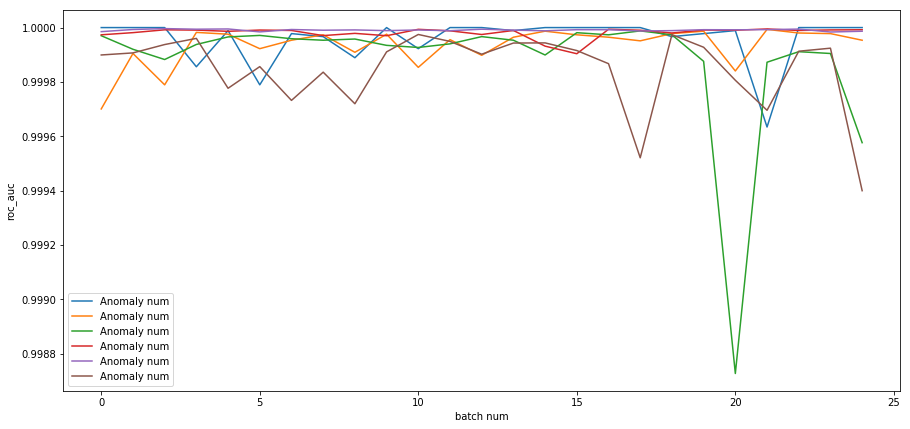

In [14]:
plt.figure(figsize=(15,7))
for anomaly_num in [10, 50, 100, 500, 1000, 6000]:
    experiment = Experiment(api_key=api, project_name="roc_auc mnist", workspace="comet-ml testing")
    experiment.log_metric("anomalies amount", anomaly_num)
    train_loader = fixed_anomaly_loader(anomaly_num * 6)
    test_loader = fixed_anomaly_loader(anomaly_num, False, 512)
    roc_aucs = []
    for i in tqdm_notebook(range(epoch)):
        model.train()
        for j,(image,label) in enumerate(train_loader):
            image = image.to(device)
            label = label.view(len(label), 1).float()
            label = label.to(device)
            predict = model(image)
            loss = criterion(predict, (label != anomaly_digit).float())
            experiment.log_metric("bin cross entropy loss", loss.cpu().detach().numpy())
            loss.backward()
            opt.step()
            opt.zero_grad()  
        model.eval()
        roc_auc = 0 
        predictions, labels = np.array([]), np.array([])
        for j,(image,label) in enumerate(test_loader):
            predict = model(image.to(device))
            if predictions.size == 0:
                predictions = predict.view(predict.shape[0]).cpu().detach().numpy()
                labels = label
            else:
                predictions = np.hstack((predictions, predict.view(predict.shape[0]).cpu().detach().numpy()))
                labels = np.hstack((labels, label))
        roc_auc = roc_auc_score((labels != anomaly_digit).astype(int), predictions)
        experiment.log_metric("roc auc", roc_auc)
        roc_aucs.append(roc_auc)
    print(f'Epoch: {i}\t Loss: {loss.item()} ROC AUC: {np.array(roc_aucs).mean()}')
    plt.plot(roc_aucs, label="Anomaly num {}".format(anomaly_num))
    plt.xlabel("batch num")
    plt.ylabel("roc_auc")
plt.legend()

In [6]:
print(device)

cuda


# AnoGAN

Основная идея [AnoGAN](https://arxiv.org/abs/1703.05921) - находить аномалии на основе расстояния до ближайшего соседа в пространстве латентных переменных. Алгоритм состоит из двух этапов:
1. На первом этапе обучается дискриминатор и генератор в стандартном режиме на нормальных объектах. При этом предполается, что генератор выучивает некоторое преобразование из латентного многообразия Z в пространство нормальных объектов
2. На втором этапе для каждого нового объекта считается расстояние до латентного многообразия, в котором сконцентрированы нормальные объекты. Те объекты, расстояние от которых до многообразия слишком большое, принимаются за аномалии

![](https://i.ibb.co/ZmzwMfS/image.png)

# AnoGAN. Этап 1. Обучение генератора на нормальных объектах

## JS GAN MNIST

In [6]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
             nn.Dropout(0.4)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [7]:
# Discriminator receives 1x28x28 image and returns a float number
# we can name each layer using OrderedDict

class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 16,kernel_size=7,padding=3),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.Conv2d(16,32,kernel_size=5,padding=2),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(32),    
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.MaxPool2d(kernel_size=2) #batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(32, 64, kernel_size=3, padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(),
                        nn.Dropout(0.1),
                        nn.MaxPool2d(kernel_size=2), # batch x 64 x 7 x 7
                        nn.Conv2d(64, 32, kernel_size=3,padding=1),  # batch x 32 x 7 x 7
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(32*7*7, 256),
                        nn.BatchNorm1d(256),
                        nn.LeakyReLU(),
                        nn.Dropout(0.4),
                        nn.Linear(256, 1)
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        
        feature = out
        out = self.fc(out)
        return out,feature

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU()
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1)
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [19]:
#GAN - JS

generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_opt = torch.optim.Adam(generator.parameters(), lr= 1e-2)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr= 1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_n_test(epochs, lmbd=10):
    BATCH_SIZE = 256
    experiment = Experiment(api_key=api, project_name="MNIST GAN-JS", workspace="comet-ml testing")
    k, m = 2, 4
    with experiment.train():
        for epoch in tqdm_notebook(range(epochs)):
            generator.train()
            discriminator.train()
            train_loader = iter(fixed_anomaly_loader(0, BATCH_SIZE))
            n = len(train_loader)
            for i in range(n // k):
                for _ in range(k):
                    disc_opt.zero_grad()
                    noise = sample_noise(BATCH_SIZE, 100)
                    gen_data = generator(noise.to(device))
                    real_data, _ = next(train_loader)
                    real_data = real_data.to(device)
                    disc_fake, _ = discriminator(gen_data)
                    disc_real, _ = discriminator(real_data)
                    disc_loss = -logsigmoid(disc_real).mean() - logsigmoid(-disc_fake).mean()
                    experiment.log_metric("discriminator loss", disc_loss.cpu().detach().numpy())
                    disc_loss.backward()
                    disc_opt.step()
                for _ in range(m):
                    gen_opt.zero_grad() 
                    noise = sample_noise(BATCH_SIZE, 100).to(device)
                    gen_data = generator(noise)
                    if (i % 10) == 0:
                        plt.figure(figsize = (15,10))
                        plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])
                        experiment.log_figure()
                        plt.close('all')
                    disc, _ = discriminator(gen_data)
                    gen_loss = -logsigmoid(disc).mean()
                    experiment.log_metric("genetator loss", gen_loss.cpu().detach().numpy())
                    gen_loss.backward()
                    gen_opt.step() 
            generator.eval()
            discriminator.eval()     
            plt.figure(figsize = (15,10))
            plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])
            experiment.log_figure()
        experiment.end() 

In [20]:
def yet_another_iteration(k=5):
    train_n_test(k)
    noise = sample_noise(256, 100).to(device)
    gen_data = generator(noise)
    plt.figure(figsize = (15,10))
    plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])

In [ ]:
yet_another_iteration(30)

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/mnist-gan-js/c440cef072e7405aa1bfab55e8523d8d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory              : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization          : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory             : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory              : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory              : (10557456384.0, 10557456384.0)
COMET INFO:     sys.gpu.1.gpu_utilization          : (0.0, 0.0)
COMET INFO:     sys.gpu.1.total_memory             : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory              : (1438121984.0, 1438121984.0)
COMET INFO:     sys.gpu.2.free_memory              : (9537847296.0, 9537847296.0)
COMET INFO:     sys.gpu.2.gpu_utilization  

COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded
COMET ERROR: File could not be uploaded


In [ ]:
#WGAN - GP

generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_opt = torch.optim.Adam(generator.parameters(), lr= 1e-3)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_n_test(epochs, lmbd=10):
    BATCH_SIZE = 1000
    train_loader = iter(fixed_anomaly_loader(0))
    experiment = Experiment(api_key=api, project_name="mnist GAN", workspace="comet-ml testing")
    k, m = 2, 3
    with experiment.train():
        generator.train()
        discriminator.train()
        for epoch in tqdm_notebook(range(epochs)):
            for _ in range(len(train_loader) // k):
                for _ in range(k):
                    disc_opt.zero_grad()
                    noise = sample_noise(BATCH_SIZE, 100)
                    gen_data = generator(noise.to(device))
                    real_data, _ = next(train_loader)
                    real_data = real_data.to(device)
                    t = torch.rand(BATCH_SIZE, 1, 1, 1).to(device)
                    t = t.expand(gen_data.size())
                    in_between = t * real_data.to(device)+ (1 - t) * gen_data.to(device)
                    in_between = torch.autograd.Variable(in_between, requires_grad=True)
                    disc_in_between, _ = discriminator(in_between)
                    gradients = torch.autograd.grad(outputs=disc_in_between, inputs=in_between,
                                      grad_outputs=torch.ones(disc_in_between.data.size()).to(device),
                                      create_graph=True, retain_graph=True, only_inputs=True)[0]
                    disc_fake, _ = discriminator(gen_data)
                    disc_real, _ = discriminator(real_data)

                    disc_loss = disc_fake.mean() - disc_real.mean() + ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lmbd

                    experiment.log_metric("discriminator loss", disc_loss.cpu().detach().numpy())
                    disc_loss.backward()
                    disc_opt.step()
                for _ in range(m):
                    gen_opt.zero_grad() 
                    noise = sample_noise(BATCH_SIZE, 100).to(device)
                    gen_data = generator(noise)
                    if (i % 10) == 0:
                        plt.figure(figsize = (15,10))
                        plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])
                        experiment.log_figure()
                        plt.close('all')
                    disc, _ = discriminator(gen_data)
                    gen_loss = -disc.mean()
                    experiment.log_metric("genetator loss", gen_loss.cpu().detach().numpy())
                    gen_loss.backward()
                    gen_opt.step() 
        experiment.end() 

In [0]:
def yet_another_iteration(k=5):
    train_n_test(k)
    noise = sample_noise(1000, 100).to(device)
    gen_data = generator(noise)
    plt.figure(figsize = (15,10))
    plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])

## Задание 2
Обучите GAN любым удобным вам способом

**Внимание:** обучайте GAN только на **нормальных** объектах (цифрах)!

In [0]:
train_n_test(5, 1000)

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/mnist-gan/5bdfd6013dbc4549b71dc1a581192638
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                  : (63.4, 63.4)
COMET INFO:     sys.cpu.percent.02                  : (39.0, 39.0)
COMET INFO:     sys.cpu.percent.avg                 : (51.2, 51.2)
COMET INFO:     sys.gpu.0.free_memory               : (6731530240.0, 6731530240.0)
COMET INFO:     sys.gpu.0.gpu_utilization           : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory              : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory               : (5265424384.0, 5265424384.0)
COMET INFO:     sys.ram.total                       : (13655236608.0, 13655236608.0)
COMET INFO:     sys.ram.used                        : (2297380864.0, 2297380864.0)
COMET INFO:     train_discriminator loss [300]      : (135.6913452148

In [0]:
torch.save(model.state_dict(), 'model1.ckpt')

NameError: ignored

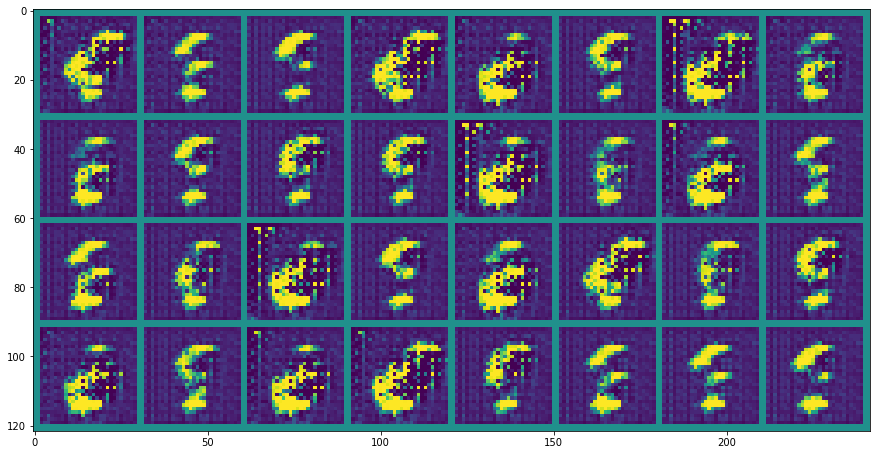

In [0]:
noise = sample_noise(1000, 100).to(device)
gen_data = generator(noise)
plt.figure(figsize = (15,10))
plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])

## AnoGAN. Этап 2. Подсчёт расстояния до нормальных объектов и подбор 

## Задание 3
Реализуйте расстояние до аномалий согласно формуле, предложенной в [статье](https://arxiv.org/abs/1703.05921):
$$L(x,G_z)=(1-\lambda)|x-G_z| + \lambda|D(x)-D(G_z)|$$, где x - аномалия (или нормальный объект), $G_z=G(z)$ - объект, сгенерированный генератором $G$ из латентного представления $z\in Z$

In [0]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x,G_z,Lambda=0.1): # расстояние до аномалии x до G_z. На выходе должен возвращаться тензор (batch_size,)
    return (1 - Lambda) * (torch.x - G_z).norm(1) + Lambda * (Discriminator(x) - Discriminator(G_z)).norm(1)

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

start_idx = 64
train_size = 500


train_data_mnist = mnist_train.__dict__['data'][start_idx:start_idx+train_size]
train_label_mnist = mnist_train.__dict__['targets'][start_idx:start_idx+train_size] == anomaly_digit # 0 - нормальный объект, 1 - аномалия
train_data_mnist = train_data_mnist.view(train_size,1,28,28).type_as(torch.FloatTensor())
train_data_mnist.size()

torch.Size([500, 1, 28, 28])

## Задание 4
Теперь, имея расстояние между двумя объектами, найдите ближайших соседей в латентном пространстве $Z$ для каждого из объектов выборки train_data_mnist. Поиск ближайшего соседа для каждого из объектов производится путём градиентной минимизации расстояния по переменной $z$.

Имея теперь расстояние до ближайшего соседа для каждого объекта выборки train_data_mnist, можно интерпретировать это расстояние как скор модели - чем больше это расстояние, тем больше вероятность, что ваш объект - аномалия, и наоборот.

Посмотрите, как по мере обучения (по мере поиска ближайшего соседа) меняется это расстояние. Принимая это расстояние за скор модели, посмотрите, как по мере обучения меняется ROC AUC. Сравните результат с baseline. Стало ли лучше?

In [0]:
z = Variable(init.normal(torch.zeros(train_size,100),mean=0,std=0.1),requires_grad=True) # для каждого объекта берём случайный нормальный объект в латентном пространстве в качестве начального соседа
z_optimizer = torch.optim.Adam([z],lr=1e-4) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям

gen_fake = generator(z.cuda())
loss = Anomaly_score(Variable(train_data_mnist).cuda(),gen_fake) # расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
print(loss.shape)
print(loss.mean())

/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


torch.Size([500])
tensor(23418.8535, device='cuda:0', grad_fn=<MeanBackward0>)


In [0]:
for i in range(5000):
    ??? # Write your code here

## Задание 5
Посмотрим на ближайших соседей

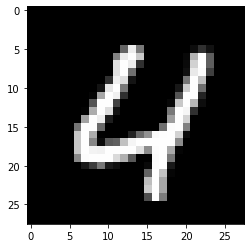

real data


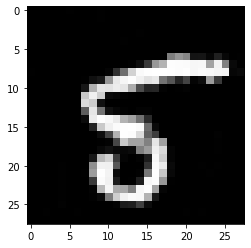

nearest neighbour

------------------------------------



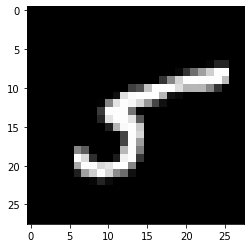

real data


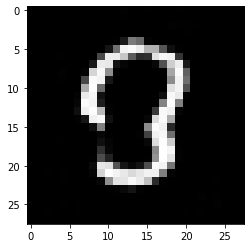

nearest neighbour

------------------------------------



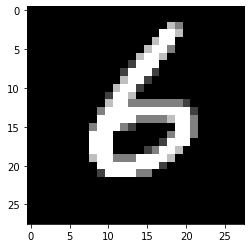

real data


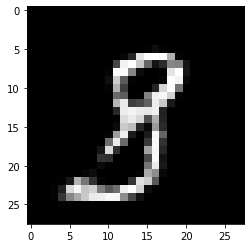

nearest neighbour

------------------------------------



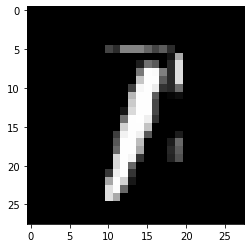

real data


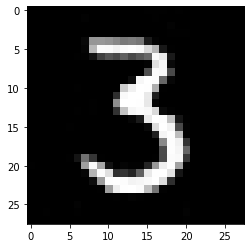

nearest neighbour

------------------------------------



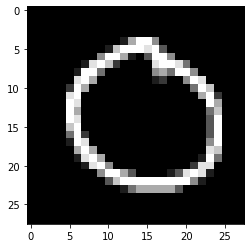

real data


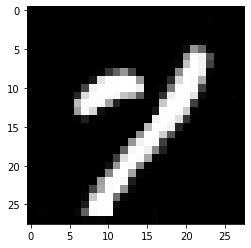

nearest neighbour

------------------------------------



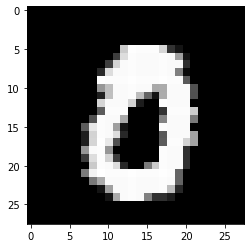

real data


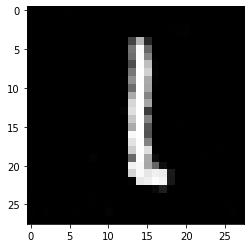

nearest neighbour

------------------------------------



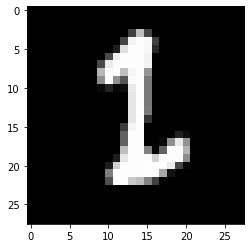

real data


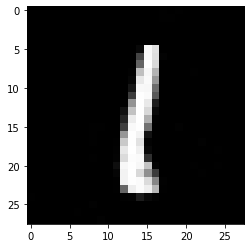

nearest neighbour

------------------------------------



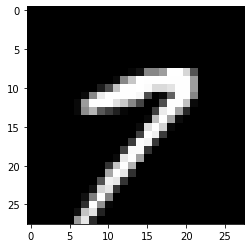

real data


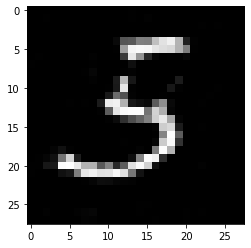

nearest neighbour

------------------------------------



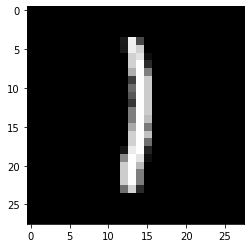

real data


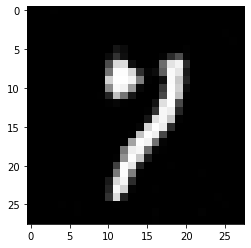

nearest neighbour

------------------------------------



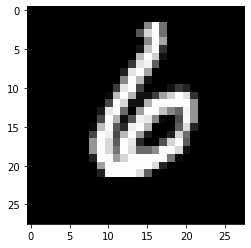

real data


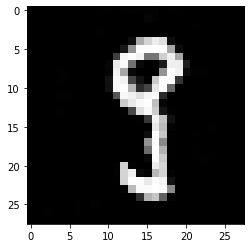

nearest neighbour

------------------------------------



In [0]:
??? # Write your code here

## Задание 6
Построим распределение расстояний для нормальных и аномальных объектов.
Что можно сказать, глядя на это распределение?

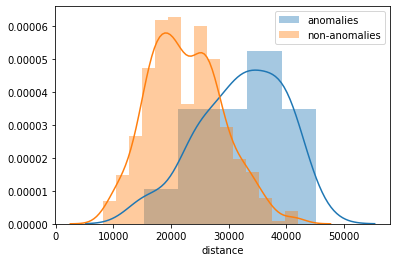

In [0]:
%matplotlib inline
import seaborn as sns
sns.distplot(loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.legend()

## Задание 7 (*)
Попробуйте обучить baseline (классификатор) на большем количестве аномалий. Стал ли классификатор работать лучше AnoGAN и, если да, с какого момента?